<a href="https://colab.research.google.com/github/Stefano-t/AMD-SM2L-2019-20-project/blob/master/dataframe_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Kaggle and download the dataset

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

!mkdir ~/.kaggle
!echo '{"username":"stefanotaverni","key":"c22f4c36169267251f92367e36c7d6fc"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d census/2013-american-community-survey
!mkdir /content/data
print("unzip folder...")
!unzip /content/2013-american-community-survey.zip -d /content/data > /dev/null
print("download completed")

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=2193f4c46cce228450bc0b7b4ea715022f897f30e5ddda2f3e7b48b1926720cc
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
100% 916M/916M [00:07<00:00, 100MB/s] 
100% 916M/916M [00:07<00:00, 122MB/s]
unzip folder...
download completed


# Download Spark and setup the environment

In [2]:
!rm spark-3.0.1-bin-hadoop2.7.tgz*
print("update system and install jdk 8")
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
print("download and extract Spark...")
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz > /dev/null
!pip install -q findspark

print("setup Spark...")
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession

spark_driver_memory = "8g"
spark_executor_memory = "1g"

spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.execuror.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .getOrCreate()
print("Spark session created")
import pyspark
sc = spark.sparkContext
print("Spark context created")

rm: cannot remove 'spark-3.0.1-bin-hadoop2.7.tgz*': No such file or directory
update system and install jdk 8
download and extract Spark...
setup Spark...
Spark session created
Spark context created


# VARIABLES
Definition of the main variables to work with.

In [3]:
import numpy as np

In [4]:
dataset_to_load = "ss13pusa.csv"
dataset_sample_fraction = 0.1
dataset_sample_seed = 1965
"""Determine how to divide the loaded dataset.

The fraction must be a value > 0 and <= 1, and the seed determines the random
seed used to split the starting dataset.
"""

target_label = 'PINCP'
forbidden_columns = ['PERNP', 'WIGP']
"""Label to predict and columns to remove."""


split_weights = [0.9, 0.1]
split_seed = 12345
"""Determine how to split the pre-processed Dataframe.

The first weight refers to the training set, and the second to the test set.
They both need to be values between 0 and 1, and sum up to 1.
"""

missing_label_substitution = "zero"
"""string: how to fill the missing values in target label

Setting the variable to "zero" means substitute empty target cell with 0; a
value of None means removing the entire row where datum is missing.
"""

nan_substitution_strategy = 'mean'
"""string: The strategy to use to remove NaN.

The string can assume the following values:
    - "mean"
    - "median"
"""

pca_new_space_dimension = 50
"""int: Number of features to preserve with PCA """

cross_validation_folds = 5
cross_validation_internal_split_seed = 1234
cross_validation_alphas = [*np.logspace(-8, 0, 7), *np.logspace(0.1, 3, 8)]
"""Number of folds and list of alphas to use in cross validation.

Alphas must be a list of values, each of which will be used as ridge regression
hyperparameter.

The seed is used for internal splitting of the folds.
"""

caching = True
"""bool: Decide to cache or not some RDDs. """

outlier_strategy = "iqr"
"""string: The strategy used to trim outliers

The admitted string are:
    - "iqr" = use the interquartile range.

If set to None, no trim is performed.
"""

number_of_partitions = sc.defaultParallelism * 2
"""int: Define the level of parallelelism to use

By default, `defaultParallelism` corresponds to the number of cores of the machine.
As a rule of thumbs, a good choice for the number of partitions is two/three times
the amount of cores.
"""

verbose = True
"""bool: Print information about some expensive operation.

This flag is used as a guard for some cpu expensive operation: set it to False
to increase the execution time.
"""

print()

# Load data into DataFrame

In [5]:
# base_path = "/home/stefano/codes/progetto_amd_prova/"
base_path = '/content/data/'
df = spark.read.csv(base_path + dataset_to_load,
                    inferSchema=True,
                    header=True) \
               .sample(withReplacement=False,
                       fraction=dataset_sample_fraction,
                       seed=dataset_sample_seed)

if verbose:
    print('The loaded dataframe has the following shape: {} rows - {} columns'
          .format(df.count(), len(df.columns)))

The loaded dataframe has the following shape: 161090 rows - 283 columns


In [6]:
if verbose: df.describe(target_label).show()

+-------+-----------------+
|summary|            PINCP|
+-------+-----------------+
|  count|           132969|
|   mean|36060.03375974851|
| stddev|55033.52019558743|
|    min|           -11600|
|    max|          1088000|
+-------+-----------------+



# Preprocessing

## remove unused columns

In [7]:
# remove banned columns
print('The following columns cannot be used in prediction: {}'.format(forbidden_columns))
df = df.drop(*forbidden_columns)
print('The new total number of column is {}'.format(len(df.columns)))

# remove columns of string type
print('Remove columns which have string type')
str_type_cols = [t[0] for t in df.dtypes if t[1] == 'string']
print('The following columns are going to be removed: {}'.format(str_type_cols))
df = df.drop(*str_type_cols)
print('The new total number of column is {}'.format(len(df.columns)))
print()

The following columns cannot be used in prediction: ['PERNP', 'WIGP']
The new total number of column is 282
Remove columns which have string type
The following columns are going to be removed: ['RT', 'NAICSP', 'SOCP']
The new total number of column is 279



In [8]:
import pyspark.sql.functions as F

In [9]:
# cast all values to float
print('Casting all values to float\n')
df = df.select(*(F.col(c).cast("float").alias(c) for c in df.columns))

Casting all values to float



## manage missing values in target label

In [10]:
if missing_label_substitution == "zero":
    df = df.fillna({target_label: 0})
else:
    df = df.filter(df[target_label].isNotNull())
if verbose: 
    print("The new total number of rows is {}".format(df.count()))

The new total number of rows is 161090


# Split dataframe into training and test set

In [11]:
df_train, df_test = df.randomSplit(split_weights,
                                   seed=split_seed)

print("Dimensions: training set = {}, test set = {}"
      .format(df_train.count(),
              df_test.count()))

Dimensions: training set = 144734, test set = 16356


## find out and trim the outliers

In [12]:
def compute_quantiles(dataframe, percentiles, approx):
    return dataframe.approxQuantile(target_label,
                                    percentiles,
                                    approx)

In [13]:
if outlier_strategy == "iqr":
    approx = 0.01

    percentiles = [.25, .75]

    quantiles = compute_quantiles(df_train,
                                  percentiles,
                                  approx)

    min_label = df_train.select(F.min(target_label).alias("MIN")) \
                        .limit(1) \
                        .collect()[0].MIN
    max_label = df_train.select(F.max(target_label).alias("MAX")) \
                        .limit(1) \
                        .collect()[0].MAX

    iqr = quantiles[1] - quantiles[0]
    lower_whisker = quantiles[0] - iqr * 1.5
    upper_whisker = quantiles[1] + iqr * 1.5

    lower_whisker = lower_whisker if lower_whisker > min_label else min_label
    upper_whisker = upper_whisker if upper_whisker < max_label else max_label


    print("quantiles: {}\n whiskers: {},{}"
          .format(quantiles,
                  lower_whisker,
                  upper_whisker))

    df_train = df_train.filter(df_train[target_label] > lower_whisker) \
                       .filter(df_train[target_label] < upper_whisker)

    if verbose:
        df_train.describe(target_label).show()

else:
    print("no outlier trimming performed")

quantiles: [0.0, 38000.0]
 whiskers: -11600.0,95000.0
+-------+------------------+
|summary|             PINCP|
+-------+------------------+
|  count|            135710|
|   mean|20030.318451108982|
| stddev| 23175.89911253234|
|    min|          -11100.0|
|    max|           94930.0|
+-------+------------------+



## substitute NaN values with the mean of corresponding column

In [14]:
from pyspark.ml.feature import Imputer

In [15]:
%%time
# create the imputer
imputer = Imputer(strategy=nan_substitution_strategy,
                  inputCols=df.columns,
                  outputCols=df.columns)

# transoform the entire dataframe according to the model
imputer_model = imputer.fit(df_train)
df_train = imputer_model.transform(df_train)

CPU times: user 129 ms, sys: 27.9 ms, total: 157 ms
Wall time: 1min 15s


# Tranform dataset

First create a new column which is the union of all other columns except the target label.
Then scale all features, removing mean and stddev.
Finally, performe a PCA reduction over the scaled features.

In [16]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [17]:
%%time

fet_vec_output_col = "features"
std_scaler_output_col = "features_scaled"
final_output_col = "pca_features"

features = df_train.columns
features.remove(target_label)

features_vec = VectorAssembler(inputCols=features,
                               outputCol=fet_vec_output_col)

df_train = features_vec.transform(df_train)

standard_scaler = StandardScaler(inputCol=fet_vec_output_col,
                                     outputCol=std_scaler_output_col)

std_scaler_model = standard_scaler.fit(df_train)
df_train = std_scaler_model.transform(df_train)


pca = PCA(k=pca_new_space_dimension,
          inputCol=std_scaler_output_col,
          outputCol=final_output_col)

pca_model = pca.fit(df_train)
df_train = pca_model.transform(df_train)


df_train = df_train.select([target_label, final_output_col])

if verbose:
    print("Dataframe of target/features values has the following shape: {} rows, {} cols"
         .format(df_train.count(), len(df_train.columns)))

df_train.show()

Dataframe of target/features values has the following shape: 135710 rows, 2 cols
+-------+--------------------+
|  PINCP|        pca_features|
+-------+--------------------+
|40000.0|[13.6324862861924...|
|10300.0|[8.47200530498123...|
|32100.0|[19.2754211897966...|
| 5800.0|[17.2285739057173...|
|25000.0|[9.81750039754862...|
|20000.0|[8.24891068712797...|
|    0.0|[43.1772331421336...|
|    0.0|[43.1917084329363...|
|65000.0|[12.4411860937025...|
|    0.0|[11.9961712499833...|
|52000.0|[10.8739027186457...|
|35000.0|[12.3922076497665...|
|73000.0|[10.7148185820928...|
|11000.0|[9.59668959158559...|
|    0.0|[9.78736320496081...|
|    0.0|[19.7342972782481...|
|27000.0|[19.7390800093674...|
|    0.0|[18.1876681969526...|
|    0.0|[15.0720734031881...|
|14400.0|[9.36701283663964...|
+-------+--------------------+
only showing top 20 rows

CPU times: user 84.9 ms, sys: 13.7 ms, total: 98.6 ms
Wall time: 3min 39s


In [18]:
print("PCA retained variance: {}"
     .format(sum(pca_model.explainedVariance)))

PCA retained variance: 0.6539303121997792


# Apply changes to test dataframe


In [19]:
df_test = imputer_model.transform(df_test)

df_test = features_vec.transform(df_test)
df_test = std_scaler_model.transform(df_test)

df_test = pca_model.transform(df_test)

df_test = df_test.select([target_label, final_output_col])

df_test.show()

+--------+--------------------+
|   PINCP|        pca_features|
+--------+--------------------+
| 53000.0|[11.6342379944668...|
| 45400.0|[15.0570197856349...|
| 15000.0|[21.0080653752614...|
| 50000.0|[12.4094068073228...|
|   780.0|[12.0739007792263...|
| 20000.0|[16.5461618028497...|
| 63000.0|[18.3365049031775...|
| 22500.0|[12.9402567587973...|
|  9200.0|[11.9561656120535...|
| 26600.0|[13.1601813792062...|
|     0.0|[13.3620580758227...|
|     0.0|[19.1958029466928...|
| 23000.0|[12.1866782682206...|
|     0.0|[11.9873467223289...|
|   880.0|[9.82390968675147...|
|  4220.0|[16.2928186425093...|
|     0.0|[22.8007843783457...|
| 35000.0|[17.4613910721197...|
|  8800.0|[9.81420619211907...|
|120000.0|[20.2451166433767...|
+--------+--------------------+
only showing top 20 rows



# Create RDD from DataFrame

In [20]:
training_set = df_train.rdd
test_set = df_test.rdd

print(training_set.take(3))
print(test_set.take(3))

[Row(PINCP=40000.0, pca_features=DenseVector([13.6325, 0.0853, 83.2376, -50.3635, -18.8911, 21.9402, -14.9776, -50.3937, -31.5226, 121.8372, -54.5186, -76.5295, 325.5155, 37.3692, -137.7339, 17.3955, -66.213, -137.4382, 87.8619, 67.2541, 21.4968, 4.9371, 13.4411, 2.0411, -44.2507, 3.8374, 21.6328, 28.4333, 13.3834, -53.9963, -21.3063, -20.5373, 21.6479, 8.5446, -4.5578, -9.3939, 2.8014, -17.9414, 27.3006, 23.7703, 7.932, 3.5842, 7.0831, -20.3963, -5.2537, 13.3827, 5.7059, 63.5839, -32.5431, -27.5743])), Row(PINCP=10300.0, pca_features=DenseVector([8.472, 0.1141, 75.2942, -50.8987, -22.445, 26.014, -14.4624, -48.9645, -31.9792, 121.4062, -55.0399, -77.9655, 324.3305, 38.448, -140.1146, 16.5421, -66.0692, -136.855, 87.4111, 67.4457, 21.3948, 7.2619, 13.5258, 4.2575, -44.926, 3.697, 20.9031, 29.968, 12.4629, -53.9185, -19.1327, -21.0582, 21.6615, 8.2657, -5.3489, -8.7411, 3.5757, -19.6439, 25.4714, 26.1927, 9.5953, 0.681, 6.82, -20.0962, -5.0155, 13.9231, 5.5066, 64.0478, -33.2149, -27.27

In [21]:
from pyspark.mllib.feature import LabeledPoint

In [22]:
def to_labeledPoint(row, label_col, features_col):
    label = row[label_col]
    # DenseVector can't be used to create a LabeledPoint
    features = row[features_col].values
    return LabeledPoint(label, features)

In [23]:
training_set = training_set.map(lambda row: to_labeledPoint(row,
                                                            target_label,
                                                            final_output_col))

test_set = test_set.map(lambda row: to_labeledPoint(row,
                                                    target_label,
                                                    final_output_col))
if caching: test_set.cache()

training_set = training_set.repartition(12)
test_set = test_set.repartition(12)

print(training_set.take(3))
print(test_set.take(3))

[LabeledPoint(44000.0, [16.860897359186602,0.07963893162862652,83.93587835279459,-50.33880965686178,-18.38329976260558,21.565671958822538,-15.059462933804951,-50.73355037599135,-31.081526274158186,121.77629492276799,-54.31085639625604,-76.96378241111033,325.8341264658051,37.29407134910344,-137.72873071980666,16.74986755095756,-65.37526490489903,-137.67859149782998,89.02600034919011,67.66495763091524,21.14728467707734,3.8357134921657314,13.831189174930042,2.411191009436442,-43.61047147641573,4.487395828059593,20.60176755128367,28.32206163073832,13.480690475341467,-53.56004340033765,-22.042747387672446,-19.83232108234571,20.92669890103254,8.45471072327581,-5.299080349475856,-11.29802335913941,2.921910899330318,-16.928391910233813,26.466653796211073,23.600493569089526,7.7084024825224,4.091538211435723,9.454897963099004,-22.11252367375812,-6.057689397625005,13.719903886492759,4.637735373741475,62.85938349350685,-32.950605116675675,-27.35646601783155]), LabeledPoint(3600.0, [19.108068505183

# Function estimator

In [24]:
def squared_err(expected, prediction):
    '''Compute the squared error, i.e. the squared difference between the inputs'''    
    return (expected - prediction) ** 2

In [25]:
def mean_squared_error(rdd):
    '''Compute the mean squared error of the given RDD.
    
    The RDD must be of the form RDD[(float, float)]
    '''
    return rdd.map(lambda p: squared_err(*p)).mean()

In [26]:
def root_mean_squared_error(rdd):
    '''Computes the root mean squared error of the given RDD.
    
    The RDD in input must be of the form RDD[(float, float)]'''
    return np.sqrt(mean_squared_error(rdd))

In [27]:
def r2(rdd):
    '''Computes the R2 coefficient of determination
    
    The RDD in input must be of the form RDD[(float, float)], where the first float
    is the actual value, and the second float is the predicted value.
    '''
    mean_ = rdd.map(lambda t: t[0]).mean()
    sum_squares = rdd.map(lambda t: (t[0] - mean_)**2).sum()
    residual_sum_squares = rdd.map(lambda t: squared_err(*t)).sum()
    return 1 - (residual_sum_squares / sum_squares)

# Baseline algorithm


In [28]:
# get label main
label_mean = training_set.map(lambda lp: lp.label).mean()

# create and RDD of (label, prediction)
baseline_train_prediction_rdd = training_set.map(lambda lp: (lp.label, label_mean))

# predict test set
baseline_test_prediction_rdd = test_set.map(lambda lp: (lp.label, label_mean))

## compute stats
# mse
baseline_train_mse = mean_squared_error(baseline_train_prediction_rdd)
baseline_test_mse = mean_squared_error(baseline_test_prediction_rdd)

# rmse
baseline_train_rmse = root_mean_squared_error(baseline_train_prediction_rdd)
baseline_test_rmse = root_mean_squared_error(baseline_test_prediction_rdd)

print('BASELINE VALUES\n'
      '\tMSE:\n\ttrain: {:.5e}\n\ttest: {:.5e}'.format(baseline_train_mse, baseline_test_mse))
print('\tRMSE:\n\ttrain: {:.5e}\n\ttest: {:.5e}'.format(baseline_train_rmse, baseline_test_rmse))

BASELINE VALUES
	MSE:
	train: 5.37118e+08
	test: 2.76667e+09
	RMSE:
	train: 2.31758e+04
	test: 5.25991e+04


# Ridge regression

In [29]:
def outer_product(lp):
    '''Computes the outer product of the features of the LabeledPoint with themselves.
    
    This method is meant to be used inside a map function of an RDD[LabeledPoint]
    
    The outer product of the input is defined as:
        lp.features x lp.features'
    returning an m x m matrix, with m dimension of the vector lp.features
    '''
    return np.array([np.dot(i,lp.features) for i in lp.features])

In [30]:
def outer_sum(m1, m2):
    '''Sums two matrixes'''
    return m1+m2

In [31]:
def stripes_product(rdd):
    '''Multiplies the design matrix with the feature vector of corresponding label
    
    The input must be and RDD[LabeledPoint]
    
    Computes a matrix-vector product, multipling each feature vector with the corresponding scalar label.
    It is not necessary to transponse the matrix.
    '''
    return rdd.map(lambda lp: lp.label*lp.features).reduce(lambda v1, v2: v1+v2)

In [32]:
def ridge_regression(rdd, alpha=1):
    '''Creates the ERM weights according to Ridge Regression model
    
    The RDD in input must be of the form RDD[LabeledPoint]
    '''
    A = rdd.map(outer_product).reduce(outer_sum)
    np.fill_diagonal(A, A.diagonal()+alpha)
    V = stripes_product(rdd)
    return np.linalg.inv(A).dot(V)

In [33]:
def predict(weights, features):
    '''Predicts the output according to the given weights and features'''
    return np.dot(weights, features)

In [34]:
def cross_validation(rdd, k, alpha_set, m=None, seed=None, verbose=False):
    '''Computes the cross validation over the given RDD
    
    The RDD in input must be of the form RDD[LabeledPoint]
    
    The returned value is a dictonary, where the keys are the given alpha inside
    alpha_set, and the values are a list of tuple, where each tuple is of the form:
            (fold error, fold r2 score)
    '''
    # split the rdd into k folds
    split_weights = np.repeat(1/k, k)
    folds = rdd.randomSplit(split_weights, seed=seed)
    
    if m is None:
        m = rdd.count()
        if verbose: print("count computed")

    scaling_factor = k / m
    risks = {a: [] 
             for a 
             in alpha_set}
    
    for i in range(k):
        Di = folds[i] # validation fold
        if caching: Di.cache()
        Si = folds[:i] + folds[i+1:] # all folds except Di
        training_part = sc.union(Si) # creates testing RDD
        training_part = training_part.repartition(12)
        
        for alpha in alpha_set:
            _w = ridge_regression(training_part, alpha)
            predicted_rdd_ = Di.map(lambda lp: (lp.label, predict(_w, lp.features)))
            fold_r2 = r2(predicted_rdd_)
            fold_error = scaling_factor * predicted_rdd_.map(lambda t: squared_err(*t)) \
                                                        .sum()
            risks[alpha].append((fold_error, fold_r2))
            if verbose: print('.', end='')
        if caching: Di.unpersist()
        print(" fold {} computed".format(i+1))

    return risks


In [35]:
%%time

# call once for all CV
m = training_set.count()

risks = cross_validation(training_set,
                         cross_validation_folds, 
                         cross_validation_alphas, 
                         m=m, 
                         seed=cross_validation_internal_split_seed, 
                         verbose=True)

............... fold 1 computed
............... fold 2 computed
............... fold 3 computed
............... fold 4 computed
............... fold 5 computed
CPU times: user 5.08 s, sys: 5.05 s, total: 10.1 s
Wall time: 1h 7min 49s


In [36]:
cv_risks = {
    alpha: [t[0] for t in risk]
    for alpha, risk 
    in risks.items()
}

scores = {
    alpha: [t[1] for t in risk]
    for alpha, risk 
    in risks.items()
}

# computes CV risks
for k, v in cv_risks.items():
    cv_risks[k] = sum(v) / len(v)

min_alpha, min_risk = min(cv_risks.items(), key=lambda t: t[1])

print("The minimum risk is {:.5E}, given by alpha={:.6}"
      .format(min_risk, min_alpha))

The minimum risk is 1.60109E+08, given by alpha=148.398


In [37]:
import seaborn as sbn
import matplotlib.pyplot as plt

Plot the expected risk against alpha value

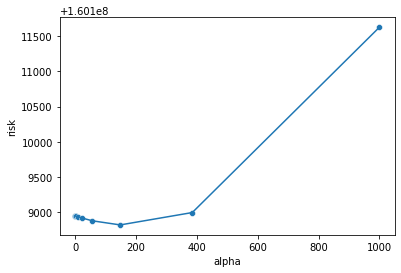

In [38]:
alpha_values = list(cv_risks.keys())
expected_risks = list(cv_risks.values())

_ = sbn.lineplot(x=alpha_values,
                 y=expected_risks)
ax = sbn.scatterplot(x=alpha_values,
                     y=expected_risks)
ax.set_xlabel("alpha")
_ = ax.set_ylabel("risk")

Plot the R2 score against the alpha value

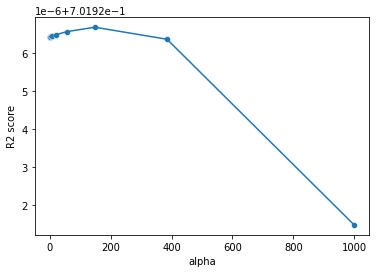

In [39]:
mean_scores = [np.mean(i)
               for i
               in scores.values()]

_ = sbn.lineplot(x=list(scores.keys()),
             y=mean_scores)
ax = sbn.scatterplot(x=list(scores.keys()),
             y=mean_scores)
ax.set_xlabel("alpha")
_ = ax.set_ylabel("R2 score")

In [40]:
weights = ridge_regression(training_set, alpha=min_alpha)
#print(weights)
#print("weights computed")

# prediction the same training set
ridge_train_prediction_rdd = training_set.map(lambda lp:
                                              (lp.label, predict(weights,
                                                                 lp.features)))

# prediction onto test set
ridge_test_prediction_rdd = test_set.map(lambda lp:
                                         (lp.label, predict(weights,
                                                            lp.features)))

# compute stats
# mse
ridge_train_mse = mean_squared_error(ridge_train_prediction_rdd)
ridge_test_mse = mean_squared_error(ridge_test_prediction_rdd)

# rmse
ridge_train_rmse = root_mean_squared_error(ridge_train_prediction_rdd)
ridge_test_rmse = root_mean_squared_error(ridge_test_prediction_rdd)

# r2
ridge_train_r2 = r2(ridge_train_prediction_rdd)
ridge_test_r2 = r2(ridge_test_prediction_rdd)

print('RIDGE REGRESSION\n'
      'Train\n'
      '\tMSE: {:.5e}\n'
      '\tRMSE: {:.5e}\n'
      '\tR2: {:.3}'
      .format(ridge_train_mse,
              ridge_train_rmse,
              ridge_train_r2))

print('Test\n'
      '\tMSE: {:.5e}\n'
      '\tRMSE: {:.5e}\n'
      '\tR2: {:.3}'
      .format(ridge_test_mse,
              ridge_test_rmse,
              ridge_test_r2))

RIDGE REGRESSION
Train
	MSE: 1.59939e+08
	RMSE: 1.26467e+04
	R2: 0.702
Test
	MSE: 1.30941e+09
	RMSE: 3.61858e+04
	R2: 0.509


Plot the prediction of ridge regression model against the true value of the label.

The smaller and the lighter the point, the better the prediction is.

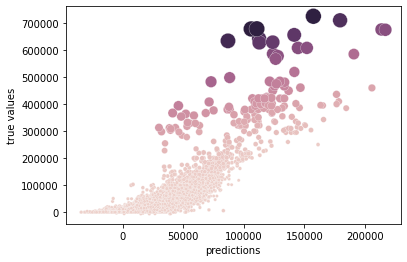

In [41]:
%matplotlib inline

predictions = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: t[1]) \
        .collect())

actual = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: t[0]) \
        .collect())

error = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: squared_err(*t)) \
        .collect())

    
ax = sbn.scatterplot(x=predictions,
                     y=actual,
                     hue=error,
                     size=error,
                     sizes=(10, 250))

ax.set_ylabel("true values")
_ = ax.set_xlabel("predictions")
ax.legend().remove()